Necessary imports
dataset: Represents mutations
model: GNN


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("./src")
from model import *
from dataset import MutationDataset
from torch_geometric.loader import DataLoader
import torch
from torch import nn
from tqdm import tqdm
from IPython.display import clear_output
import copy
import os
import time
from make_dataset import make_dataset
from torch_geometric.loader import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ExponentialLR, LinearLR
os.environ['KMP_DUPLICATE_LIB_OK']='True'

/home/babaid/miniconda3/envs/bio/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
To use the Graphein submodule graphein.protein.features.sequence.embeddings, you need to install: biovec 
biovec cannot be installed via conda
To use the Graphein submodule graphein.protein.visualisation, you need to install: pytorch3d 
To do so, use the following command: conda install -c pytorch3d pytorch3d


In [ ]:
make_dataset(index_xlsx="../index.xlsx", root="../dataset")

In [4]:
dataset = MutationDataset(index_xlsx="index.xlsx", root="datasetmf")
train_size = int(len(dataset)*0.8)#0.8042)
val_size = len(dataset)-train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=True)

In [5]:
print("Length test dataset: ", len(val_dataset))
print("Length train dataset: ", len(train_dataset))

Length test dataset:  989
Length train dataset:  3954


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ddGPredictor().to(device)
print("Using {} device".format(device))

Using cuda device


In [7]:
optimizer = torch.optim.Adam(model.parameters())
scheduler = ExponentialLR(optimizer, gamma=0.9)
loss_fn =  nn.MSELoss()

In [8]:
writer = SummaryWriter()
epochs = 500
model.train()

for epoch in tqdm(range(1, epochs)):
    epoch_loss = 0.
    best_loss = 1000.
    model.train()
    for i, batch in enumerate(train_loader) :
        x, y = batch["mutated"].to(device), batch["non_mutated"].to(device)
        ddg = x.ddg.to(device).squeeze()
        optimizer.zero_grad()
        out = model(x,y).squeeze()
        loss = loss_fn(out, ddg)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        clear_output(wait=True)
        
    epoch_loss/=len(train_loader)
    #if epoch%5==0:
        #scheduler.step()
    writer.add_scalar("Loss/train", epoch_loss, epoch)
    print("Epoch: {}, Loss: {}".format(epoch, epoch_loss))
    
    
    model.eval()
    val_loss = 0

    for i, batch in enumerate(val_loader):
        x, y = batch["mutated"].to(device), batch["non_mutated"].to(device)
        ddg = x.ddg.to(device).squeeze()
        out = model(x,y).squeeze()
        loss = loss_fn(out, ddg)
        val_loss+=loss.item()
    val_loss /= len(val_dataset) 
    writer.add_scalar("Loss/val", val_loss, epoch)
    
    print("Validation loss:", val_loss)
    
    
    if epoch_loss<best_loss:
        best_model = copy.deepcopy(model)
        
        torch.save(model.state_dict(), "model.pt")
    else:
        
        scheduler.step()

    

  0%|          | 0/499 [00:00<?, ?it/s]

In [ ]:
traced = torch.jit.trace()

In [8]:
model.eval()
d = next(iter(train_loader))
model(d["mutated"].cuda(), d["non_mutated"].cuda()).squeeze()

tensor([ 0.6876,  0.4225,  3.5669, -0.5802,  4.6596,  0.4645, -0.4728,  3.6043,
         0.5778, -0.8629,  0.1091,  2.9981,  0.9646,  3.7513,  1.5096,  0.0978,
         1.5636,  1.7756,  1.1558,  2.1811,  0.1841,  2.1580,  2.4402,  0.4550,
         0.5201, -0.4020, -0.9937, -0.0279,  0.6844, -1.8958,  3.0846,  0.8049,
        -0.2682,  0.3863,  1.5394,  0.4249,  0.7748,  1.8250, -1.6186,  3.0599,
         2.1580, -0.9913,  3.2073,  0.3591,  2.3626, -0.6421, -0.0393, -0.0524,
         3.2601,  3.6216, -0.8543,  0.5287,  0.2824,  0.6509,  2.9981,  1.0988,
         1.1032, -0.9563,  3.2120,  1.6378,  0.9792,  3.3441, -0.0729,  1.6175],
       device='cuda:0', grad_fn=<SqueezeBackward0>)

In [9]:
d["mutated"].ddg

tensor([ 0.7977,  1.0528,  3.6802,  0.4238,  4.2813,  1.5628,  0.5150,  2.3082,
         1.9027, -1.6601, -0.2112,  2.6322, -1.4917,  4.1745,  1.5962, -0.2385,
         2.1318,  2.4246,  2.2142,  1.9676, -0.1760,  2.5754,  4.3984, -0.7045,
         0.4406,  1.0604, -1.7043, -0.1103, -1.2249, -2.0916,  2.3570,  1.8965,
        -0.1321,  1.6637,  2.4669,  0.1923,  1.8231,  3.8650, -1.8733,  3.9681,
         2.6213, -1.4668,  2.6618,  1.2788,  2.0758,  0.6974, -0.0670,  0.8209,
         2.4188,  4.1623,  0.0000,  0.0389,  0.3575, -0.2458,  2.7556,  0.6513,
         0.3354, -0.9057,  2.3166,  0.2957,  2.3777,  1.2402,  1.5745,  0.8168],
       device='cuda:0')

100%|██████████| 200/200 [00:06<00:00, 33.05it/s]


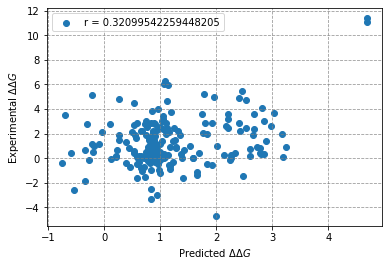

In [25]:
from src.visualize import comparator
model.load_state_dict(torch.load("model.pt"))
comparator(model, train_dataset,200, "cuda")

In [ ]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

from ray import tune
from ray.tune.schedulers import ASHAScheduler

In [ ]:
def train(model, optimizer, train_loader, writer):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    epoch_loss=0
    for i, batch in enumerate(train_loader) :
        x, y = batch["mutated"].to(device), batch["non_mutated"].to(device)
        ddg = x.ddg.to(device).squeeze()
        optimizer.zero_grad()
        out = model(x,y).squeeze()
        loss = loss_fn(out, ddg)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    writer.add_scalar("RUN/Loss/train", epoch_loss, epoch)
    print("Epoch Loss: {}".format(epoch_loss))

def test(model, data_loader, writer):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    val_loss = 0
    with torch.no_grad():
        
        for i, batch in enumerate(val_loader):
            
            x, y = batch["mutated"].to(device), batch["non_mutated"].to(device)
            ddg = x.ddg.to(device).squeeze()
            out = model(x,y).squeeze()
            loss = loss_fn(out, ddg)
            val_loss+=loss.item()/len(val_dataset)
        print("Validation loss:", val_loss)
    return val_loss
    

In [ ]:
def train_ddg(config):
    
    

    dataset = AffMutationDataset(index_xlsx="skempi_cleansed.xlsx", root="dataset")
    train_size = int(len(dataset)*0.8042)
    val_size = len(dataset)-train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size= 32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = ddGPredictor(config).to(device)
    

    optimizer = optim.SGD(
        model.parameters(), lr=config["lr"], momentum=config["momentum"])
    
    for i in range(10):
        train(model, optimizer, train_loader, writer)
        acc = test(model, val_loader)

        # Send the current training result back to Tune
        tune.report(mean_accuracy=acc)

        if i % 5 == 0:
            # This saves the model to the trial directory
            torch.save(model.state_dict(), "./model.pth")

In [ ]:
search_space = {
    "lr": tune.sample_from(lambda spec: 10 ** (-10 * np.random.rand())),
    "momentum": tune.uniform(0.1, 0.9),
    "features_in" : 20, 
    "features_hidden":30, 
    "gnn_features_out":tune.choice([30, 25, 20]), 
    "mlp_hidden_dim" : tune.choice([[30, 30, 30,], [50], [30], [20, 20], [20], [100], [100, 50], [1000], [1000, 500]]), 
    "out_dim":1
    
}

In [ ]:
analysis = tune.run(train_dataset, config=search_space)

In [13]:
dataset[0]["mutated"].edge_index.shape

torch.Size([2, 621])

In [96]:
from graphein.protein.graphs import construct_graph
from graphein.ml.conversion import GraphFormatConvertor
from graphein.protein.edges.atomic import add_atomic_edges, add_bond_order, add_ring_status
from graphein.protein.edges.distance import add_hydrogen_bond_interactions, add_ionic_interactions, add_peptide_bonds
from graphein.protein.edges.distance import compute_distmat

from graphein.protein.config import ProteinGraphConfig
params_to_change = {"granularity": "atom", "edge_construction_functions": [add_atomic_edges, add_bond_order, add_hydrogen_bond_interactions, add_ionic_interactions, add_peptide_bonds]}
config = ProteinGraphConfig(**params_to_change)
graph_mutated = construct_graph(config=config,pdb_path="datasetmf/raw/temp/1_mutated_interface.pdb")

/home/babaid/miniconda3/envs/bio/lib/python3.7/site-packages/rich/live.py:229: UserWarning:

install "ipywidgets" for Jupyter support

In [ ]:
graph_mutated.edges[('C:PRO:6:CB', 'E:ALA:96:O')]

In [97]:
from graphein.protein.visualisation import plotly_protein_structure_graph

p = plotly_protein_structure_graph(
    graph_mutated,
    colour_edges_by="kind",
    colour_nodes_by="element_symbol",
    label_node_ids=False,
    node_size_min=5,
    node_alpha=0.85,
    node_size_multiplier=1,
    plot_title="Atom-level graph. Nodes coloured by their Element"
    )
p.show()

In [ ]:
graph_mutated2 = construct_graph(config=config,pdb_path="dataset_3/raw/temp/0_mutated_interface.pdb")
p = plotly_protein_structure_graph(
    graph_mutated2,
    colour_edges_by="kind",
    colour_nodes_by="element_symbol",
    label_node_ids=False,
    node_size_min=5,
    node_alpha=0.85,
    node_size_multiplier=1,
    plot_title="Atom-level graph. Nodes coloured by their Element"
    )
p.show()

In [ ]:
format_convertor = GraphFormatConvertor('nx', 'pyg', verbose="default")


In [ ]:
pyg_graph_mutated = format_convertor(graph_mutated)
from graphein.protein.edges.distance import add_hydrogen_bond_interactions, add_ionic_interactions, add_peptide_bonds
#config = ProteinGraphConfig()


# Create backbone graph with additional interactions
#edge_funcs = [add_hydrogen_bond_interactions, add_ionic_interactions, add_peptide_bonds]

#c#onfig = ProteinGraphConfig(edge_construction_functions= edge_funcs)
from graphein.protein.edges.distance import compute_distmat
##graph_mutated = construct_graph(config=config,pdb_path="dataset/raw/temp/0_mutated_interface.pdb")



In [102]:
def ew(g):
    
  
    nodes = {x:i for i, x in enumerate(graph_mutated.nodes)}
    w = torch.zeros((len(nodes), len(nodes)))
    for k, (u, v, a) in enumerate(graph_mutated.edges(data = True)):
        i, j = nodes[u], nodes[v]
        w[i, j] = a["distance"]
    return w

In [107]:
print(ew(graph_mutated))
pyg_graph_mutated.edge_index


tensor([[0.0000, 1.4649, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.5204,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.5165, 1.5646],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


tensor([[ 0,  1,  1,  2,  2,  4,  5,  5,  6,  7,  8,  9, 10, 11, 12, 13, 13, 14,
         14, 16, 17, 17, 18, 19, 20, 21, 21, 22, 22, 24, 25, 26, 27, 27, 28, 28,
         30, 30, 32, 33, 34, 34, 35, 37, 37, 38, 41, 42, 42, 43, 43, 45, 45, 47,
         48, 49, 49, 50, 50, 52, 52, 54, 55, 56, 56, 57, 57, 59, 60, 60, 62, 63,
         64, 64, 65, 65, 67, 68, 68, 69, 70, 71, 72, 72, 73, 75, 76, 76],
        [ 1,  2,  4,  3, 12,  5,  6,  7,  8,  9, 10, 10, 11, 12, 13, 14, 16, 15,
         20, 17, 18, 19, 19, 20, 21, 22, 24, 23, 26, 25, 26, 27, 28, 30, 29, 33,
         31, 32, 33, 34, 35, 37, 36, 38, 39, 40, 42, 43, 45, 44, 48, 46, 47, 48,
         49, 50, 52, 51, 55, 53, 54, 55, 56, 57, 59, 58, 63, 60, 61, 62, 63, 64,
         65, 67, 66, 71, 68, 69, 70, 70, 71, 72, 73, 75, 74, 76, 77, 78]])

In [90]:
for el in a["kind"]:
    print(el)

covalent
SINGLE


In [84]:
b = pd.DataFrame(bonds)

In [86]:
b[0].unique()

array(['SINGLE', 'DOUBLE', 'peptide_bond', 'hbond'], dtype=object)

In [ ]:
list(a["kind"])

In [ ]:
edge_features = []
for edge in graph_mutated.edges:
    node = 

In [ ]:
pyg_graph_mutated.edge_index[1, 2]

In [ ]:
dist_mat = dist_mat.to_numpy()

In [ ]:
ei = pyg_graph_mutated.edge_index


In [ ]:
edge_weights = []
for i in range(ei.shape[1]):
    edge_weights.append(1/dist_mat[ei[0, i].item(), ei[1, i].item()])
w = torch.tensor(edge_weights)

In [ ]:
ei.reshape(ei.shape[1], ei.shape[0]).unique(dim =1).shape

In [ ]:
torch_geometric.utils.coalesce(ei).shape

In [ ]:
from graphein.protein.visualisation import plot_distance_matrix

plot_distance_matrix(graph_mutated)

In [ ]:
plt.plot([0, 10], [0, 0], label="$\\mathbf{NONE}$", c="r", linewidth=5)
plt.xlabel("$\\mathbf{x}$")
plt.ylabel("$\\mathbf{Number \\ of \\ fucks \\ I  \\ give}$")
plt.grid(c="grey", alpha=0.6)
plt.legend();

In [ ]:
d = dataset[0]["mutated"]
d

In [ ]:
d.edge_weight

In [ ]:
index_df = pd.read_excel("./renumbered_index.xlsx", converters={"pdb_id":str.lower, "mut_id":str.strip, "ddg":float, "res_renum":int})

In [ ]:
d = np.array_split(index_df, 8)

In [ ]:
d[0]

In [ ]:
import pymol2

In [ ]:
p = pymol2.PyMOL()


In [ ]:
p2 = pymol2.PyMOL()

In [ ]:
mu = "a"

In [ ]:
import os

In [ ]:
def lower_filenames(dir):
    for file in os.listdir(dir):
        os.rename(os.path.join(dir, file), os.path.join(dir, file.lower()))



In [ ]:
os.listdir

In [ ]:
lower_filenames("PDBs")

In [ ]:
def remove_trash(dir):
    for item in os.listdir(dir):
        if item[0]=='.' or item.endswith(".mapping"):
            os.remove(os.path.join(dir, item))
        

In [ ]:
remove_trash("PDBs")

In [ ]:
import pandas as pd
mut_df = pd.read_excel("skempi_cleansed.xlsx", converters={"pdb_id":str.lower, "mut_pdb":str.strip,"mut_id":str.strip,"aff_mut":float, "aff_wt":float,"temp":float,  "ddg":float,})

In [ ]:
mut_df["mut_id"] = mut_df["mut_id"].str.split(",")

In [ ]:
mut_df = mut_df.loc[mut_df["mut_id"].str.len() == 1]

In [ ]:
dropped = mut_df.dropna(axis=0)

In [ ]:
dl = dropped.mut_id.to_list()

In [ ]:
def f(x):
    return x[0]

In [ ]:
dropped["mut_id"]=dropped["mut_id"].apply(f)

In [ ]:
dropped.to_excel("index.xlsx")

In [ ]:
mut_f = [x for x in os.listdir("dataset/processed/mutated") if x.endswith("mutated.pt")]



In [ ]:
len(mut_f)

In [ ]:
import os
import shutil
sourcepath="dataset/processed"
sourcefiles = os.listdir("dataset/processed/")
destinationpath = "dataset/processed/non_mutated"
destmut =  "dataset/processed/mutated"
for file in sourcefiles:
    if file.endswith("_non_mutated.pt"):
        shutil.move(os.path.join(sourcepath,file), os.path.join(destinationpath,file))
    else:
        pass
        #shutil.move(os.path.join(sourcepath,file), os.path.join(destinationpath,file))   
